### Fingerzeichen

In [1]:
import numpy as np
import math
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy

C:\Users\khthe\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def load_dataset():
    train_dataset = h5py.File('data/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('data/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()


y = 3


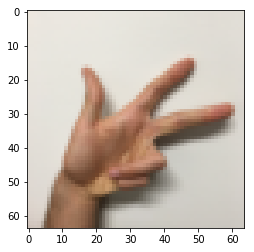

In [4]:
# Beispielbild
index = 32
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [5]:
# Wir wandeln die Eingabebilder in Vektoren um und normalisieren die Werte
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.

print ("Anzahl Trainingsbilder = " + str(X_train.shape[1]))
print ("Anzahl Testbilder = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("X_test shape: " + str(X_test.shape))


Anzahl Trainingsbilder = 1080
Anzahl Testbilder = 120
X_train shape: (12288, 1080)
X_test shape: (12288, 120)


In [6]:
# Die Ausgabedaten werden in eine one-hot-Matrix umgewandelt
Y_test = np.eye(6)[Y_test_orig.reshape(-1)].T
Y_train = np.eye(6)[Y_train_orig.reshape(-1)].T

print ("Y_train shape: " + str(Y_train.shape))
print ("Y_test shape: " + str(Y_test.shape))

Y_train shape: (6, 1080)
Y_test shape: (6, 120)


### Training ohne Minibatch

In [ ]:
tf.reset_default_graph()
tf.set_random_seed(1)                             # to keep consistent results
seed = 3                                          # to keep consistent results
n_x, m = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
n_y = Y_train.shape[0]                            # n_y : output size
costs = []  
learning_rate = 0.001
minibatch_size = 32
num_epochs = 1000

X = tf.placeholder(shape=[n_x,None],dtype='float')
Y = tf.placeholder(shape=[n_y,None],dtype='float')

# initialisierung der parameter
W1 = tf.get_variable('W1',[25,12288],initializer=tf.contrib.layers.xavier_initializer(seed=1))
b1 = tf.get_variable('b1',[25,1],initializer=tf.zeros_initializer())
W2 = tf.get_variable('W2',[12,25],initializer=tf.contrib.layers.xavier_initializer(seed=1))
b2 = tf.get_variable('b2',[12,1],initializer=tf.zeros_initializer())
W3 = tf.get_variable('W3',[6,12],initializer=tf.contrib.layers.xavier_initializer(seed=1))
b3 = tf.get_variable('b3',[6,1],initializer=tf.zeros_initializer())

# forwardprop
Z1 = tf.add(tf.matmul(W1,X),b1)                                             
A1 = tf.nn.relu(Z1)                                              
Z2 = tf.add(tf.matmul(W2,A1),b2)                                             
A2 = tf.nn.relu(Z2)                                              
Z3 = tf.add(tf.matmul(W3,Z2),b3)    

# Kosten berechnen
logits = tf.transpose(Z3)
labels = tf.transpose(Y)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))

optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        epoch_kosten = 0                       
        _ , kosten = sess.run([optimizer, cost], feed_dict={X: X_train, Y: Y_train})
        epoch_kosten += kosten

        if epoch % 50 == 0:
            print ("Kosten nach Epoche %i: %f" % (epoch, epoch_kosten))
        
        if epoch % 5 == 0:
            costs.append(epoch_kosten)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('Kosten')
    plt.xlabel('Iterationen (mal 5)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
    print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
    
    #parameter = sess.run(W1),sess.run(b1),sess.run(W2),sess.run(b2),sess.run(W3),sess.run(b3)

### Training mit Minibatch

Das Aufteilen der Trainingsdaten in kleine Portionen beschleunigt den Gang zum Minimum

In [11]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    
    m = X.shape[1]                  
    mini_batches = []
    np.random.seed(seed)
    
    # X und Y werden gemischt
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Einteilung in Portionen
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Ende-Behandlung, der letzte mini-batch ist evtl. kleiner
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches



tf.reset_default_graph()
tf.set_random_seed(1)                             # to keep consistent results
seed = 3                                          # to keep consistent results
n_x, m = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
n_y = Y_train.shape[0]                            # n_y : output size
costs = []  
learning_rate = 0.0001
minibatch_size = 32
num_epochs = 1500

X = tf.placeholder(shape=[n_x,None],dtype='float')
Y = tf.placeholder(shape=[n_y,None],dtype='float')

# initialisierung der parameter
W1 = tf.get_variable('W1',[25,12288],initializer=tf.contrib.layers.xavier_initializer(seed=1))
b1 = tf.get_variable('b1',[25,1],initializer=tf.zeros_initializer())
W2 = tf.get_variable('W2',[12,25],initializer=tf.contrib.layers.xavier_initializer(seed=1))
b2 = tf.get_variable('b2',[12,1],initializer=tf.zeros_initializer())
W3 = tf.get_variable('W3',[6,12],initializer=tf.contrib.layers.xavier_initializer(seed=1))
b3 = tf.get_variable('b3',[6,1],initializer=tf.zeros_initializer())

# forwardprop
Z1 = tf.add(tf.matmul(W1,X),b1)                                             
A1 = tf.nn.relu(Z1)                                              
Z2 = tf.add(tf.matmul(W2,A1),b2)                                             
A2 = tf.nn.relu(Z2)                                              
Z3 = tf.add(tf.matmul(W3,Z2),b3)    

# Kosten berechnen
logits = tf.transpose(Z3)
labels = tf.transpose(Y)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))

optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
init = tf.global_variables_initializer()

Kosten nach epoch 0: 1.877091
Kosten nach epoch 50: 1.606949
Kosten nach epoch 100: 1.469517
Kosten nach epoch 150: 1.370159
Kosten nach epoch 200: 1.290366
Kosten nach epoch 250: 1.219376
Kosten nach epoch 300: 1.157710
Kosten nach epoch 350: 1.101385
Kosten nach epoch 400: 1.049604
Kosten nach epoch 450: 1.002898
Kosten nach epoch 500: 0.955978
Kosten nach epoch 550: 0.913638
Kosten nach epoch 600: 0.873848
Kosten nach epoch 650: 0.838844
Kosten nach epoch 700: 0.802411
Kosten nach epoch 750: 0.767863
Kosten nach epoch 800: 0.737561
Kosten nach epoch 850: 0.708276
Kosten nach epoch 900: 0.679775
Kosten nach epoch 950: 0.651512
Kosten nach epoch 1000: 0.629291
Kosten nach epoch 1050: 0.603715
Kosten nach epoch 1100: 0.578398
Kosten nach epoch 1150: 0.557177
Kosten nach epoch 1200: 0.536484
Kosten nach epoch 1250: 0.515690
Kosten nach epoch 1300: 0.497435
Kosten nach epoch 1350: 0.479685
Kosten nach epoch 1400: 0.462647
Kosten nach epoch 1450: 0.444468


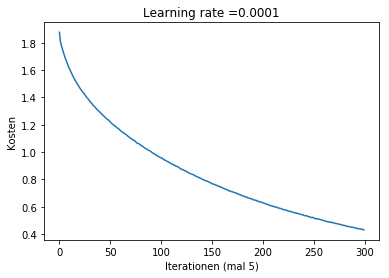

Train Accuracy: 0.90185183
Test Accuracy: 0.84166664


In [12]:
# Training
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        epoch_cost = 0                       
        num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
        seed = seed + 1
        minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch
            _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
            epoch_cost += minibatch_cost / num_minibatches

        if epoch % 50 == 0:
            print ("Kosten nach epoch %i: %f" % (epoch, epoch_cost))
        
        if epoch % 5 == 0:
            costs.append(epoch_cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('Kosten')
    plt.xlabel('Iterationen (mal 5)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
    print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
    save_path = saver.save(sess, "data/model.ckpt")                         # save Model
    

In [36]:
# Beispiele für falsche Predictions

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "data/model.ckpt")
    for index in range(200):
        p = tf.argmax(Z3) 
        X1 = X_train_orig[index] 
        X1 = X1.reshape(12288, 1)
        X1 = X1 / 255.
        prediction = sess.run(p, feed_dict = {X: X1})
        if prediction[0] != Y_train_orig[0][index]:
            print(index, "predict = ", prediction[0], 'richtig = ',Y_train_orig[0][index])
            

INFO:tensorflow:Restoring parameters from data/model.ckpt
2 predict =  1 richtig =  2
46 predict =  5 richtig =  3
64 predict =  0 richtig =  2
69 predict =  1 richtig =  2
76 predict =  1 richtig =  5
77 predict =  5 richtig =  4
80 predict =  1 richtig =  2
82 predict =  4 richtig =  5
88 predict =  5 richtig =  3
89 predict =  4 richtig =  5
93 predict =  0 richtig =  5
111 predict =  4 richtig =  2
128 predict =  4 richtig =  2
131 predict =  3 richtig =  5
136 predict =  2 richtig =  0
137 predict =  1 richtig =  2
141 predict =  0 richtig =  4
147 predict =  4 richtig =  0
159 predict =  4 richtig =  5
169 predict =  5 richtig =  4
170 predict =  2 richtig =  1
189 predict =  4 richtig =  3


### Test an eigenen Bildern

Da wird leider keins richtig geraten.

INFO:tensorflow:Restoring parameters from data/model.ckpt


C:\Users\khthe\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


[[-5.8500485 ]
 [ 1.3371441 ]
 [-0.941851  ]
 [-2.105649  ]
 [-1.6257815 ]
 [-0.74058086]]
predict =  [1]


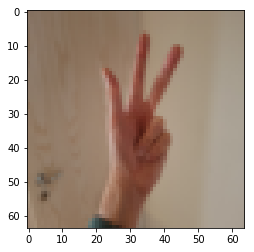

In [26]:
fname = "data/finger3a.jpg" 
image = np.array(plt.imread(fname))
image = scipy.misc.imresize(image, size=(64,64))

plt.imshow(image)
image = image / 255.

X1 = image.reshape(12288, 1)

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "data/model.ckpt")
    p = tf.argmax(Z3) 
    print(sess.run(Z3, feed_dict = {X: X1}))
    prediction = sess.run(p, feed_dict = {X: X1})
    print('predict = ',prediction)
     

In [27]:
X_train.shape

(12288, 1080)

In [28]:
X1.shape

(12288, 1)

In [32]:
X_train[0]

array([0.89019608, 0.93333333, 0.89411765, ..., 0.92156863, 0.91372549,
       0.90196078])

In [30]:
X1[0]

array([0.52941176])